In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.types import DoubleType
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder\
    .appName("Classification Décision tree")\
    .enableHiveSupport()\
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
spark.catalog.clearCache()
spark.sql("USE concessionnaire")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 10:31:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/20 10:31:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/20 10:31:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


DataFrame[]

In [3]:
clients_immatriculations = spark.sql("SELECT * FROM clients_immatriculations")
clients_immatriculations.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- taux_eligible: boolean (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)
 |-- categorie: string (nullable = true)



### Verification des doublons

In [4]:
doublons = clients_immatriculations.groupBy(*clients_immatriculations.columns).agg(count("*").alias("count")).filter("count > 1")
doublons.show(truncate=False)

+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
|immatriculation|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|categorie|count|
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+



### Analyse des **null**

In [5]:
doublons = clients_immatriculations.groupBy('nbenfantacharge').count().show()

+---------------+-----+
|nbenfantacharge|count|
+---------------+-----+
|              1|16425|
|              3|11451|
|              4| 9960|
|              2|16593|
|              0|44972|
+---------------+-----+



### Supprimer les colones innutiles

In [6]:
clients_immatriculations = clients_immatriculations.drop('immatriculation')
clients_immatriculations = clients_immatriculations.drop('couleur')
clients_immatriculations = clients_immatriculations.drop('marque')
clients_immatriculations = clients_immatriculations.drop('puissance')
clients_immatriculations = clients_immatriculations.drop('nbportes')
clients_immatriculations = clients_immatriculations.drop('occasion')
clients_immatriculations = clients_immatriculations.drop('prix')
clients_immatriculations = clients_immatriculations.drop('nbplaces') 
clients_immatriculations = clients_immatriculations.drop('modele') 
clients_immatriculations = clients_immatriculations.drop('longueur')

### OneHotEncoder

In [7]:
indexer_sexe = StringIndexer(inputCol="sexe", outputCol="sexe_index").fit(clients_immatriculations)
clients_immatriculations = indexer_sexe.transform(clients_immatriculations)

encoder_sexe = OneHotEncoder(inputCol="sexe_index", outputCol="sexe_encoded").fit(clients_immatriculations)
clients_immatriculations = encoder_sexe.transform(clients_immatriculations)

In [8]:
indexer_situationfamiliale = StringIndexer(inputCol="situationfamiliale", outputCol="situationfamiliale_index").fit(clients_immatriculations)
clients_immatriculations = indexer_situationfamiliale.transform(clients_immatriculations)

encoder_situationfamiliale = OneHotEncoder(inputCol="situationfamiliale_index", outputCol="situationfamiliale_encoded").fit(clients_immatriculations)
clients_immatriculations = encoder_situationfamiliale.transform(clients_immatriculations)

In [9]:
# clients_immatriculations = clients_immatriculations.drop('marque') 
# clients_immatriculations = clients_immatriculations.drop('marque_index')


## Changer des Boolean en Int

In [10]:
clients_immatriculations = clients_immatriculations.withColumn(
    "deuxiemevoiture",
    when(col("deuxiemevoiture") == False, 0)
    .when(col("deuxiemevoiture") == True, 1)
    .otherwise(col("deuxiemevoiture").cast("int"))
)

clients_immatriculations = clients_immatriculations.withColumn(
    "taux_eligible",
    when(col("taux_eligible") == False, 0)
    .when(col("taux_eligible") == True, 1)
    .otherwise(col("taux_eligible").cast("int"))
)

clients_immatriculations.show(4)

+----+----+-----+------------------+---------------+---------------+-------------+-------------------+----------+-------------+------------------------+--------------------------+
| age|sexe| taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|          categorie|sexe_index| sexe_encoded|situationfamiliale_index|situationfamiliale_encoded|
+----+----+-----+------------------+---------------+---------------+-------------+-------------------+----------+-------------+------------------------+--------------------------+
|61.0|   M|188.0|       celibataire|              0|              0|            0|citadine economique|       0.0|(1,[0],[1.0])|                     1.0|             (3,[1],[1.0])|
|50.0|   F|460.0|         en couple|              3|              0|            0|      suv/crossover|       1.0|    (1,[],[])|                     0.0|             (3,[0],[1.0])|
|54.0|   M|403.0|       celibataire|              0|              0|            0|citadine economiqu

## Normalisation

In [11]:
clients_immatriculations.groupBy("categorie").count().show()

+-------------------+-----+
|          categorie|count|
+-------------------+-----+
|              autre| 5796|
|          familiale|30364|
|citadine economique|26784|
|      suv/crossover|36457|
+-------------------+-----+



In [12]:
clients_immatriculations.printSchema()
clients_immatriculations.show()

root
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: integer (nullable = true)
 |-- taux_eligible: integer (nullable = true)
 |-- categorie: string (nullable = true)
 |-- sexe_index: double (nullable = false)
 |-- sexe_encoded: vector (nullable = true)
 |-- situationfamiliale_index: double (nullable = false)
 |-- situationfamiliale_encoded: vector (nullable = true)

+----+----+------+------------------+---------------+---------------+-------------+-------------------+----------+-------------+------------------------+--------------------------+
| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|          categorie|sexe_index| sexe_encoded|situationfamiliale_index|situationfamiliale_encoded|
+----+----+------+------------------+---------------+---------------+-------------+-------

## Classificateur

In [13]:
# Apprentissage des labels
indexer_model = StringIndexer(inputCol="categorie", outputCol="label").fit(clients_immatriculations)

data = indexer_model.transform(clients_immatriculations)

feature_cols = [col for col in data.columns if col not in ["categorie", "label", 'sexe', 'situationfamiliale']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data).select("features", "label")

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


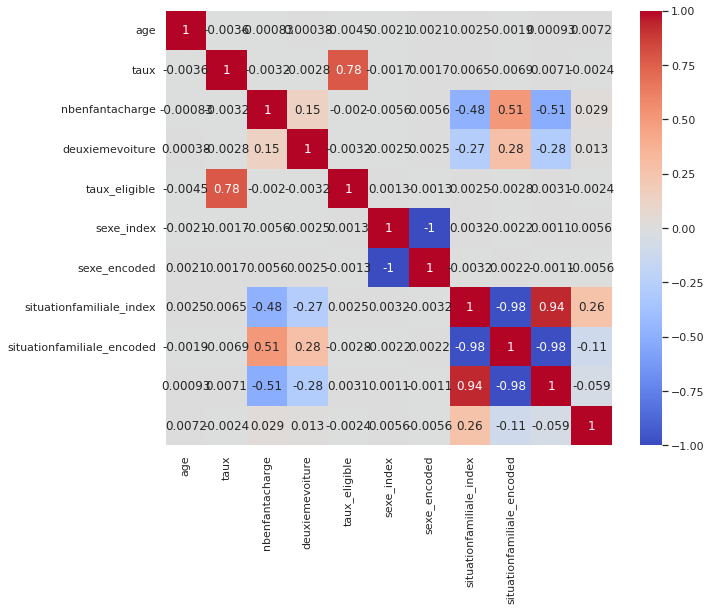

In [14]:
matrix = Correlation.corr(data, "features").head()[0]
corr_array = matrix.toArray()

# Afficher la matrice avec heatmap
sns.set(rc={"figure.figsize": (10, 8)})
sns.heatmap(corr_array, annot=True, xticklabels=feature_cols, yticklabels=feature_cols, cmap="coolwarm")
plt.show()

In [15]:
breakpoint()

In [16]:
# Diviser les données en 60% entraînement, 20% validation et 20% test
(trainingData, validationData, testData) = data.randomSplit([0.6, 0.2, 0.2], seed=42)

print(f"Taille de l'ensemble d'entraînement : {trainingData.count()}")
print(f"Taille de l'ensemble de validation : {validationData.count()}")
print(f"Taille de l'ensemble de test : {testData.count()}")

# Définir le modèle de régression linéaire
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", minInstancesPerNode=2, maxDepth=20)
dt_model = dt.fit(trainingData)

Taille de l'ensemble d'entraînement : 59929


Taille de l'ensemble de validation : 19746


Taille de l'ensemble de test : 19726


In [ ]:
# Définir les hyperparamètres à tester
param_grid = {
    'minInstancesPerNode': [1, 2, 5, 7],
    'maxDepth': [2, 5, 10, 15],
    'maxBins': [32, 64, 125, 200]
}

# Liste pour enregistrer les résultats
results = []

# Générer toutes les combinaisons d'hyperparamètres
for minInstancesPerNode, maxDepth, maxBins in product(param_grid['minInstancesPerNode'], param_grid['maxDepth'], param_grid['maxBins']):
    # Configurer le modèle avec les hyperparamètres
    dt = DecisionTreeClassifier(minInstancesPerNode=minInstancesPerNode, maxDepth=maxDepth, maxBins=maxBins, labelCol="label", featuresCol="features")
    
    # Entraîner le modèle
    model = dt.fit(trainingData)
    
    # Prédire sur les données de test
    predictions = model.transform(testData)
    
    # Évaluer la précision
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    # Enregistrer les résultats
    results.append((minInstancesPerNode, maxDepth, maxBins, accuracy))

# Trouver les meilleurs hyperparamètres
best_params = max(results, key=lambda x: x[3])  # Trier par précision
print(f"Meilleurs paramètres : minInstancesPerNode={best_params[0]}, maxDepth={best_params[1]}, maxBins={best_params[2]} avec précision={best_params[3]}")
